# This tool is used to calculate headway and print transit routs
# Ann Arbor Area Transit GTFS data is at https://www.theride.org/business/software-developers
# Author: cliu / SEMCOG
# Last update: 8/26/2025

In [1]:
import os
import pandas as pd
import numpy as np
import geopandas as gpd
from shapely.geometry import LineString
from datetime import timedelta
import matplotlib.pyplot as plt
import matplotlib.backends.backend_pdf as pdf_backend
import re
_join = os.path.join

In [2]:
GTFS_location = r'C:\cliu\Python_Scripts\0_test_folder_keep\GTFS'

## Transit Authority GTFS

In [3]:
sub_path = r'AAATA_GTFS'
auth = 'AAATA' # input 1

stop_times_df = pd.read_csv(_join(GTFS_location, sub_path,'stop_times.txt'))
trips_df = pd.read_csv(_join(GTFS_location, sub_path,'trips.txt'))

In [4]:
# Calculate route frequency
service_id = 2 # input 2 string or integer
model = 'E8' # input 3
if model == 'E8':
    time_dic = {'AM':['06:30:00', '08:59:59'],'MD':['09:00:00', '14:29:59'],'PM':['14:30:00', '18:29:59'],\
                'EV':['18:30:00', '21:59:59'], 'NT1':['22:00:00', '30:29:59'], 'NT2':['0:00:00', '6:29:59']}  # E8
    duration = {'AM': timedelta(hours=2, minutes=30),  
            'MD': timedelta(hours=5, minutes=30),
            'PM': timedelta(hours=4),
            'EV': timedelta(hours=3, minutes=30),
            'NT': timedelta(hours=8, minutes=30)}
elif model == 'ABM':
    time_dic = {'AM':['06:30:00', '08:59:59'],'MD':['09:00:00', '14:29:59'],'PM':['14:30:00', '18:29:59'],\
                'EV1':['18:30:00', '26:59:59'], 'EV2':['0:00:00', '2:59:59'], 'NT1':['3:00:00', '06:29:59'], 'NT2':['27:00:00', '30:29:59']} # ABM
    duration = {'AM': timedelta(hours=2, minutes=30), 
            'MD': timedelta(hours=5, minutes=30),
            'PM': timedelta(hours=4),
            'EV': timedelta(hours=8, minutes=30),
            'NT': timedelta(hours=3, minutes=30)}

merged_df0 = stop_times_df.merge(trips_df, on='trip_id')
merged_df = merged_df0[merged_df0['service_id'] == service_id] 
merged_df = merged_df.copy()

# only keep same stop_id with earlist arrival time   
merged_df['arrival_time'] = pd.to_timedelta(merged_df['arrival_time'])
earliest_indices = merged_df.groupby('shape_id')['arrival_time'].idxmin()
earliest_rows = merged_df.loc[earliest_indices]  
merged_df = pd.merge(merged_df, earliest_rows[['stop_id', 'shape_id']], on=['stop_id', 'shape_id'], suffixes=('_filtered', '_earliest'))

# Function to convert time to timedelta, handling values greater than 24 hours
def convert_to_timedelta(time_str):
    # Split the time string into hours, minutes, and seconds
    parts = time_str.split(':')
    hours, minutes, seconds = map(int, parts)
    
    # Calculate the total seconds for the time
    total_seconds = hours * 3600 + minutes * 60 + seconds
    
    # Create a timedelta object
    return pd.to_timedelta(total_seconds, unit='s')

df = df2 =headway_df = pd.DataFrame()
# Convert 'departure_time' to timedelta
merged_df['departure_time'] = merged_df['departure_time'].apply(convert_to_timedelta)

model_tod_map = {
    'E8': ['AM', 'MD', 'PM', 'EV', 'NT1', 'NT2'],
    'ABM': ['AM', 'MD', 'PM', 'EV1', 'EV2', 'NT1', 'NT2']
}
tod_list = model_tod_map.get(model, [])  # empty list if model not found

for time in tod_list:    
    # Define user-defined time period
    start_time = convert_to_timedelta(time_dic[time][0])
    end_time = convert_to_timedelta(time_dic[time][1])

    # Filter data within the time period
    filtered_df = merged_df[(merged_df['departure_time'] >= start_time) & (merged_df['departure_time'] <= end_time)]      

    # Sort the DataFrame by stop, and route
    filtered_df = filtered_df.sort_values(['stop_id', 'shape_id', 'direction_id', 'departure_time']).copy()

    most_common_stops = filtered_df.groupby(['shape_id', 'direction_id'])['stop_id'].agg(lambda x: x.value_counts().idxmax())
    filtered_df = filtered_df[filtered_df['stop_id'].isin(most_common_stops)]
    filtered_df['TOD'] = time[:2]    
    df = pd.concat([df, filtered_df], ignore_index=True)

# E8: Convert trips from NT to EV or EA 
if model == 'E8': 

    ea_start = pd.to_timedelta("02:00:00")
    ea_end   = pd.to_timedelta("06:29:59")

    ev_start1 = pd.to_timedelta("22:00:00")
    ev_end1   = pd.to_timedelta("25:59:59")

    ev_start2 = pd.to_timedelta("1 days 00:00:00")
    ev_end2   = pd.to_timedelta("1 days 01:59:59")

    # Only adjust rows where TOD == 'NT'
    mask_nt = df['TOD'] == 'NT'

    # Reassign to EA
    df.loc[mask_nt & (df['departure_time'].between(ea_start, ea_end)), 'TOD'] = 'EA'

    # Reassign to EV (late night or after midnight)
    df.loc[mask_nt & (df['departure_time'].between(ev_start1, ev_end1)), 'TOD'] = 'EV'
    df.loc[mask_nt & (df['departure_time'].between(ev_start2, ev_end2)), 'TOD'] = 'EV'
    
for time in ['AM', 'MD', 'PM', 'EV', 'NT']:    
  
    filtered_df2 = df[df['TOD'] == time].copy()
    filtered_df2['trip_headsign'] = filtered_df2['trip_headsign'].astype(str)
    filtered_df2['trip_headsign'].fillna(' ', inplace=True)
    # Subtract one day for values greater than '1 days 03:00:00'
    if model == 'E8' and time == 'EV':
        threshold = pd.to_timedelta('6:30:00')
        filtered_df2.loc[filtered_df2['departure_time'] < threshold, 'departure_time'] += pd.to_timedelta('1 days')
    if model == 'ABM'and time == 'EV':
        threshold = pd.to_timedelta('03:00:00')
        filtered_df2.loc[filtered_df2['departure_time'] < threshold, 'departure_time'] += pd.to_timedelta('1 days')

    if not pd.api.types.is_timedelta64_dtype(filtered_df2['departure_time']): # Ensure departure_time is timedelta
        filtered_df2['departure_time'] = pd.to_timedelta(filtered_df2['departure_time'], errors='coerce')

    # Compute time_diff safely
    filtered_df2 = filtered_df2[filtered_df2['stop_sequence'] == 1] # some stop_times.txt contains stop_sequence other than 1 which should be skipped (e.g. LET)
    time_diff = filtered_df2.groupby(['shape_id', 'direction_id', 'stop_id'])['departure_time'].diff()

    # Convert to minutes; if not timedelta, fallback to NaN
    if pd.api.types.is_timedelta64_dtype(time_diff):
        filtered_df2['time_diff'] = time_diff.dt.total_seconds() / 60
    else:
        filtered_df2['time_diff'] = time_diff  # fallback: leave as is (probably NaT or float)

    filtered_df2 = filtered_df2[['arrival_time','departure_time','stop_id','stop_sequence','timepoint',\
                               'shape_id','route_id','trip_headsign','direction_id','time_diff']]    
    df2 = pd.concat([df2, filtered_df2], ignore_index=True)
    # Consolidate headways for each route/direction by time period
    grouped = filtered_df2.groupby(['shape_id', 'route_id', 'trip_headsign', 'direction_id', 'stop_id'])

    if not filtered_df2.empty:
        if model == 'E8':
            result_df = grouped['departure_time'].agg(  # option2 only
                lambda x: duration[time] if len(x) <= 1 
                        else (x.max() - x.min()) / (len(x) - 1)
            ).reset_index(name=time)
        elif model == 'ABM':
            result_df = grouped['departure_time'].agg(  # if AM, MD, PM - option2, if EV, NT - option 1
                lambda x: duration[time] if len(x) <= 1 
                        else (duration[time] / len(x) if time in ['EV', 'NT'] 
                                else (x.max() - x.min()) / (len(x) - 1))
            ).reset_index(name=time)

        result_df.columns = ['shape_id', 'route_id', 'trip_headsign', 'direction_id', 'stop_id', time]
        result_df[time] = result_df[time].apply(lambda x: int(x.total_seconds() / 60 + 0.5) if isinstance(x, pd.Timedelta)\
                                                          else 0)
        result_df = result_df.sort_values(by=[time], ascending=[False])
        result_df = result_df.drop_duplicates(subset=['shape_id', 'route_id', 'trip_headsign', 'direction_id'], keep='first')
        
        if time == 'AM':
            headway_df = pd.concat([headway_df, result_df[['shape_id', 'route_id', 'trip_headsign', 'direction_id', time]]], ignore_index=True)
        else:
            headway_df = headway_df.merge(result_df[['shape_id', 'route_id', 'trip_headsign', 'direction_id', time]], \
                                        on = ['shape_id', 'route_id', 'trip_headsign', 'direction_id'], how = 'outer')

headway_df.fillna(999, inplace=True)   

if 'NT' in headway_df.columns:
    headway_df = headway_df.drop(headway_df[(headway_df['AM'] + headway_df['MD'] + headway_df['PM'] + headway_df['EV'] + headway_df['NT']) == 4995.0].index) # 999*5
elif 'EV' in headway_df.columns:
    headway_df = headway_df.drop(headway_df[(headway_df['AM'] + headway_df['MD'] + headway_df['PM'] + headway_df['EV']) == 3996.0].index)
else:
    headway_df = headway_df.drop(headway_df[(headway_df['AM'] + headway_df['MD'] + headway_df['PM']) == 2997.0].index)
    
df2.to_csv(auth + '_' + model + '_time_diff.csv', index=False)
headway_df.to_csv(auth + '_' + model + '_headway.csv', index=False)

# Plot

In [5]:
map_location = r'C:\cliu\Python_Scripts\0_test_folder_keep\GTFS'
street_map = gpd.read_file(_join(map_location, 'All Street Shape File\All_Street.shp'))
index_df = pd.read_csv(_join(map_location, 'All Street Shape File\model_gtfs_index.csv'))
map_format = 'all_street' # input 4

In [6]:
# Plot TRAU itineraries with background street map
shapes_df2 = pd.read_csv(_join(GTFS_location, sub_path, 'shapes.txt'))
shapes_df = trips_df.merge(shapes_df2, on='shape_id', how='left')
shapes_df = shapes_df[shapes_df['service_id'] == service_id] 
shapes_df = shapes_df.drop_duplicates(subset=['shape_id', 'shape_pt_sequence']) # removal candidate
shapes_df = shapes_df.merge(index_df, left_on='shape_id', right_on='gtfs_route', how='left')
shapes_df['model_route'].fillna('new route', inplace=True)
shapes_df['route_id'] = shapes_df['route_id'].astype(str) # need comment for UMI
time_columns = ['shape_id', 'AM', 'MD', 'PM', 'EV', 'NT']
existing_columns = [col for col in time_columns if col in headway_df.columns]

if existing_columns:
    shapes_df = shapes_df.merge(headway_df[existing_columns], on='shape_id', how='left')
    existing_columns.remove('shape_id')
    shapes_df['freq'] = shapes_df[existing_columns].astype(str).apply(','.join, axis=1)

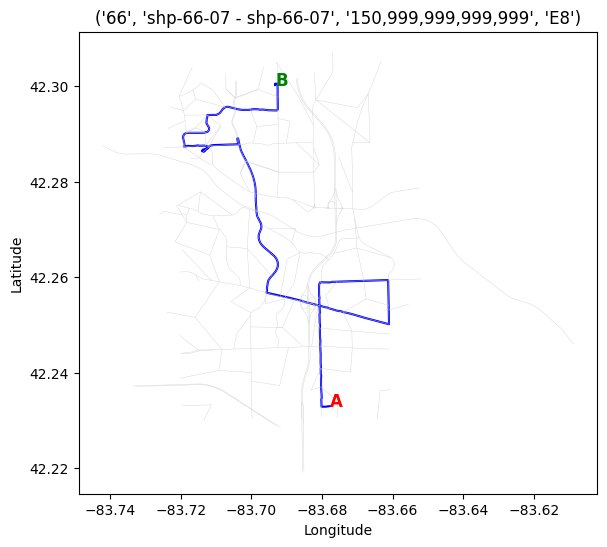

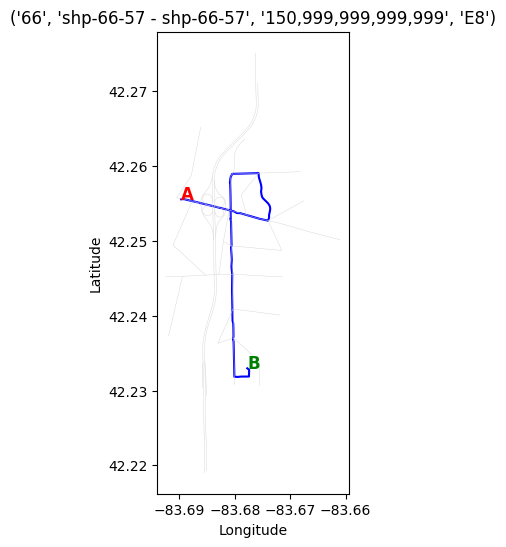

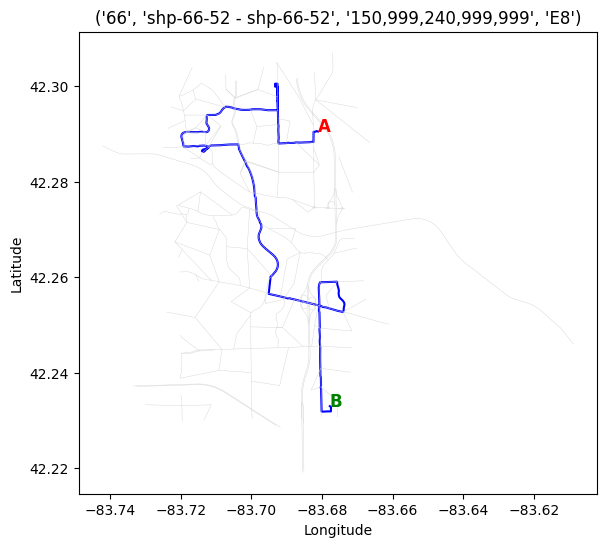

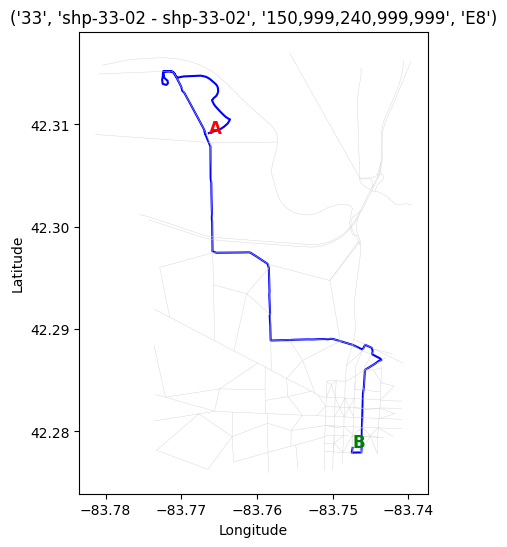

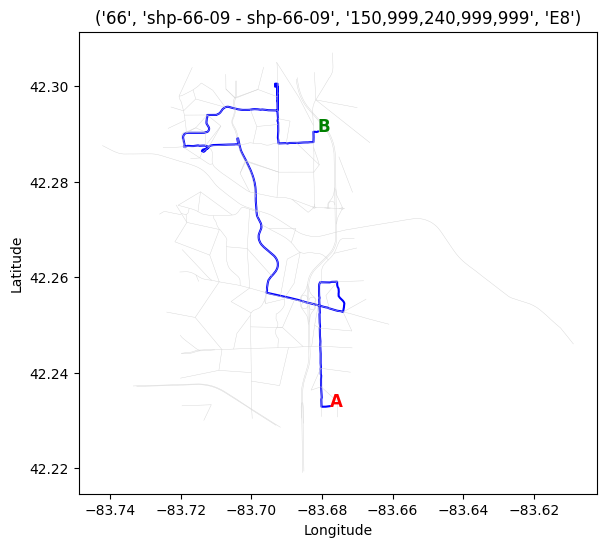

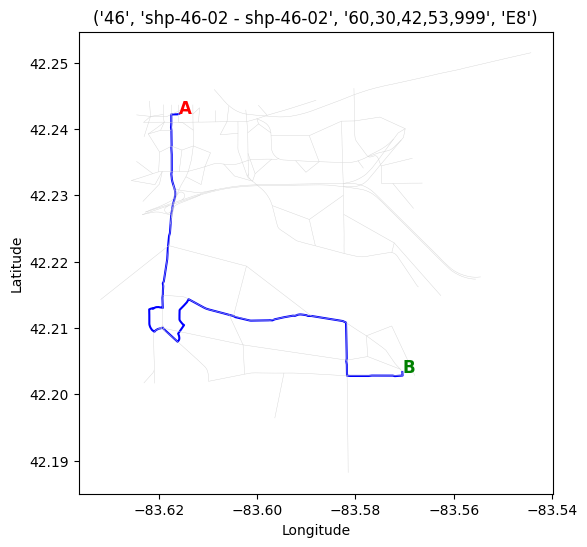

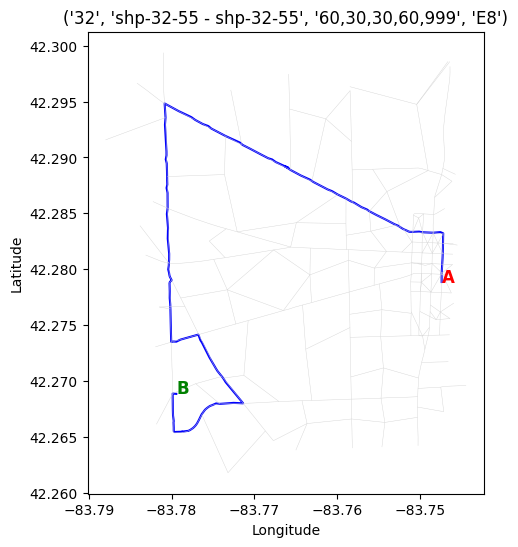

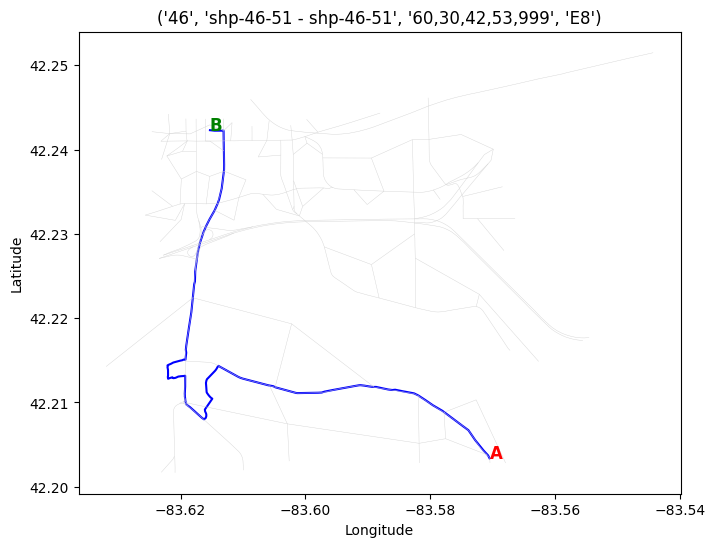

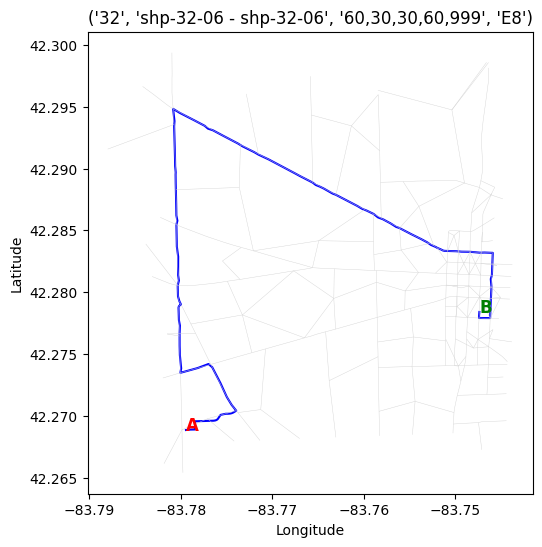

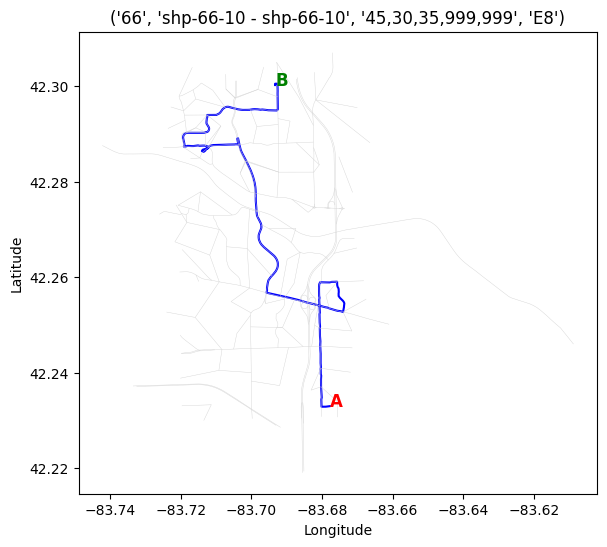

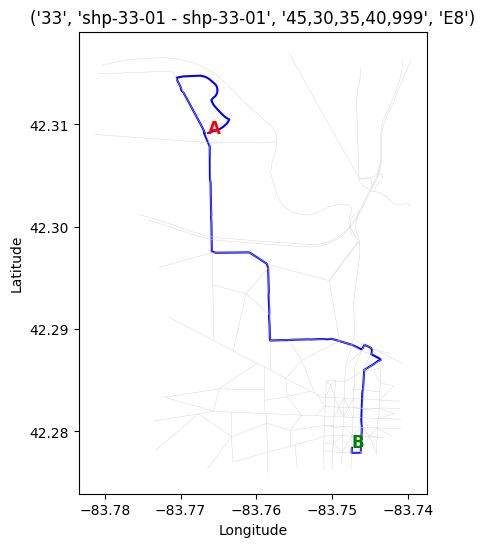

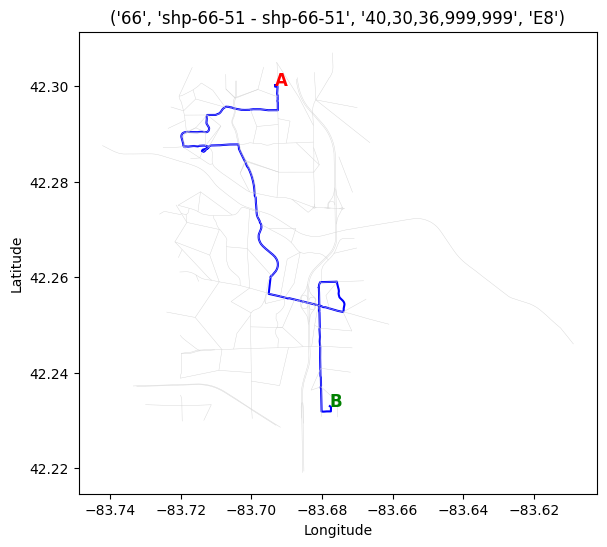

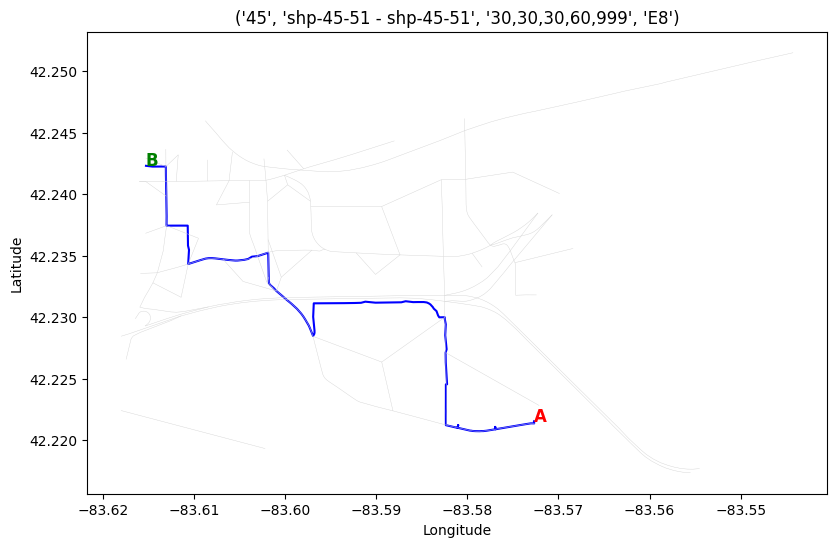

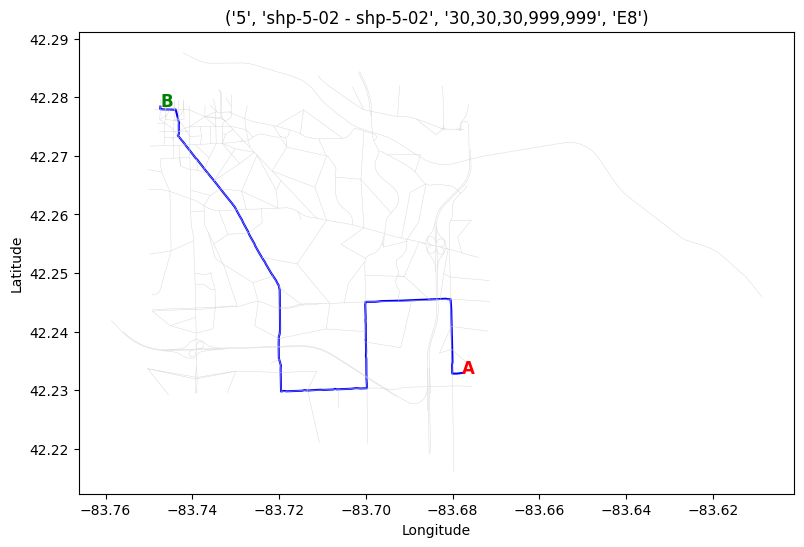

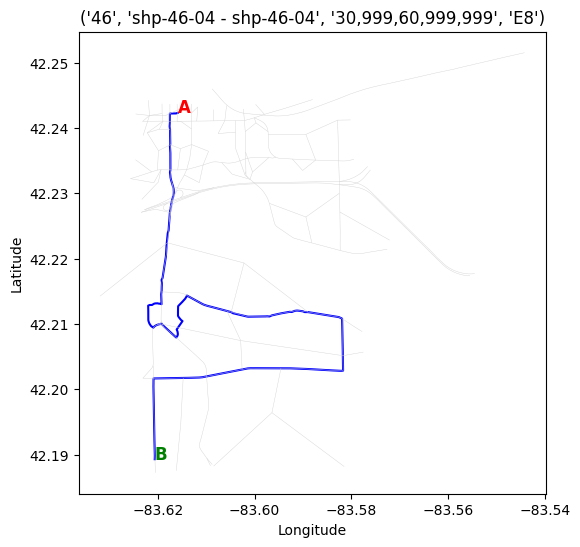

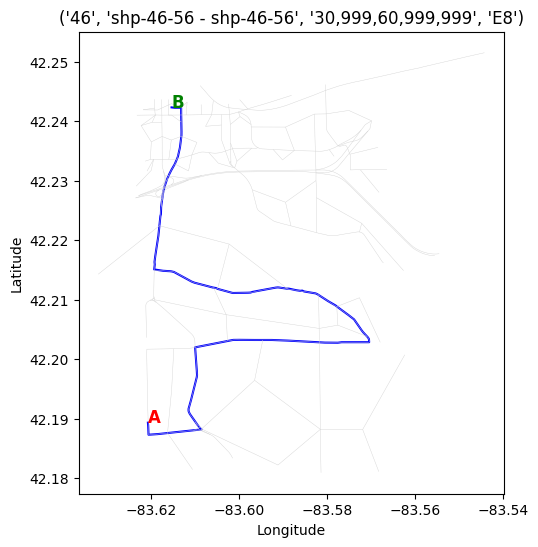

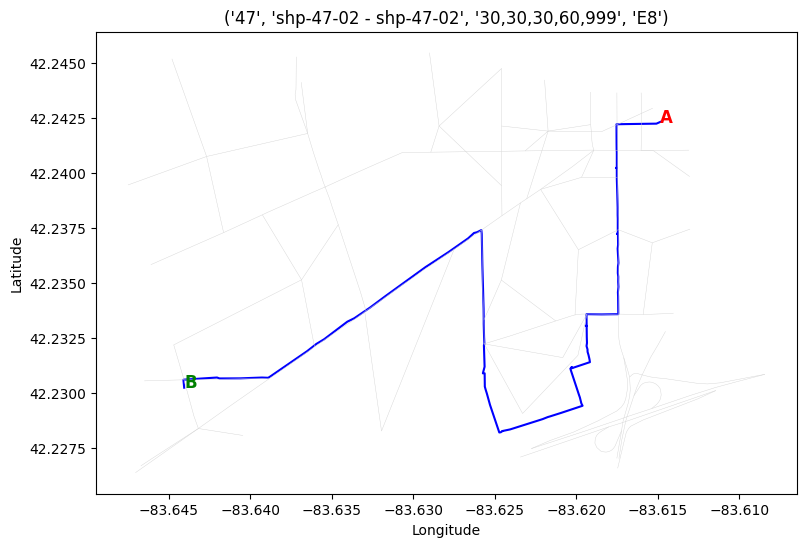

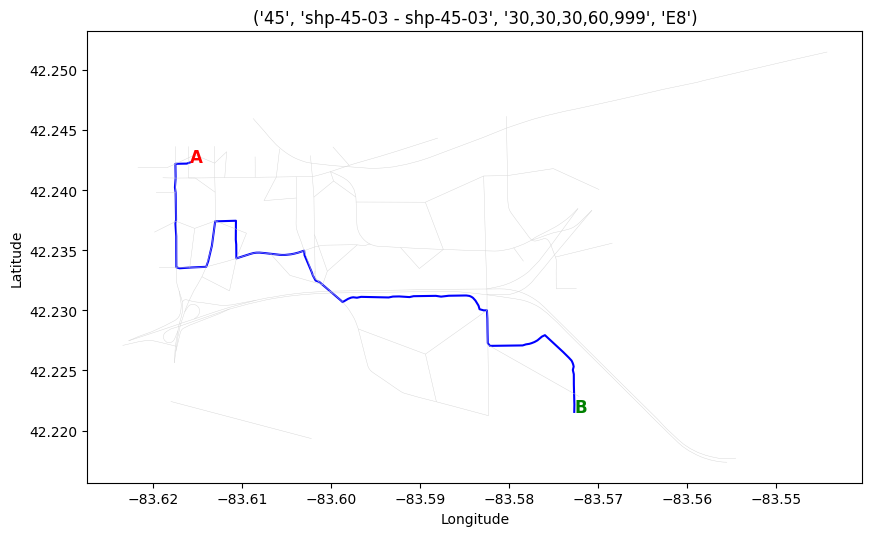

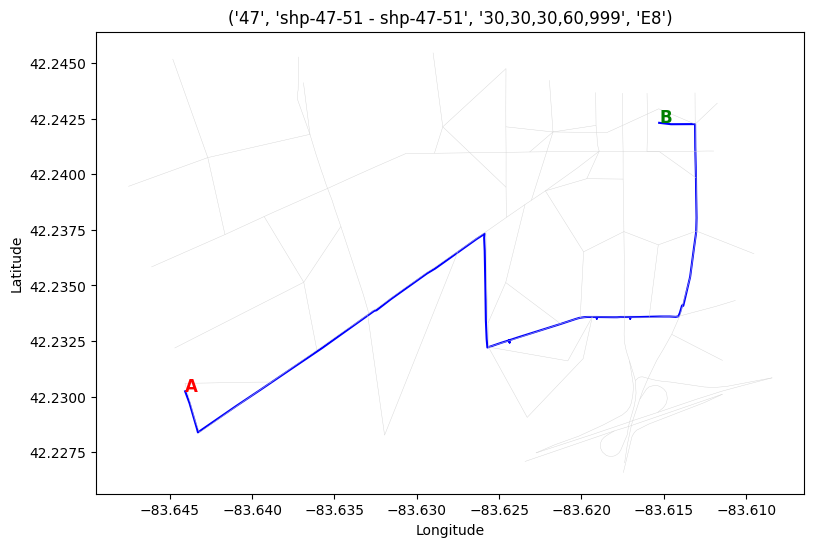

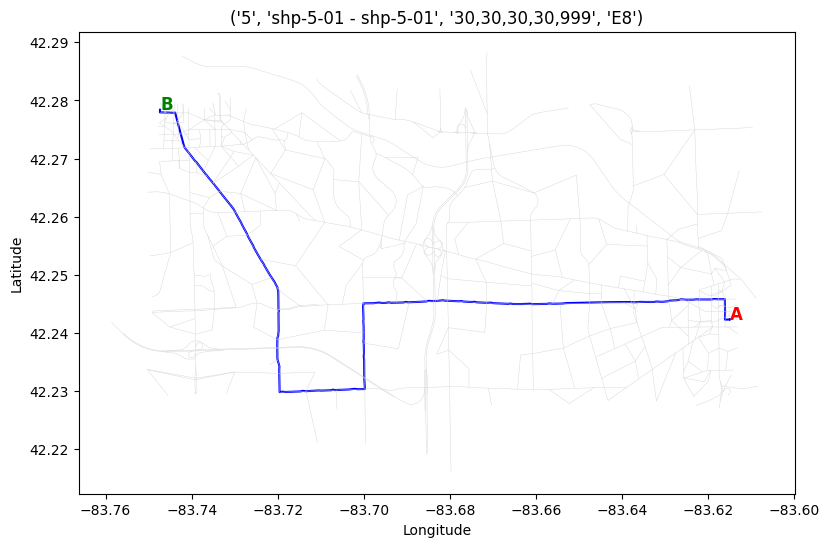

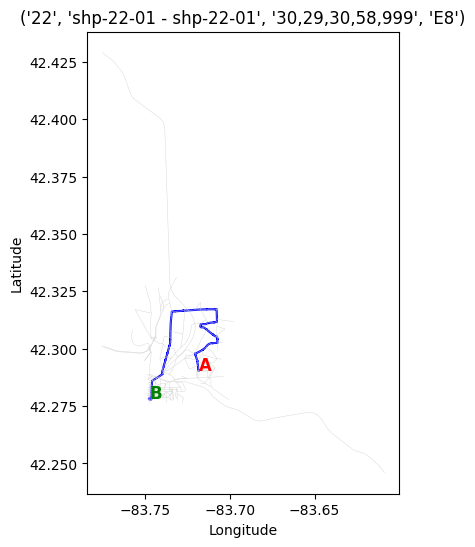

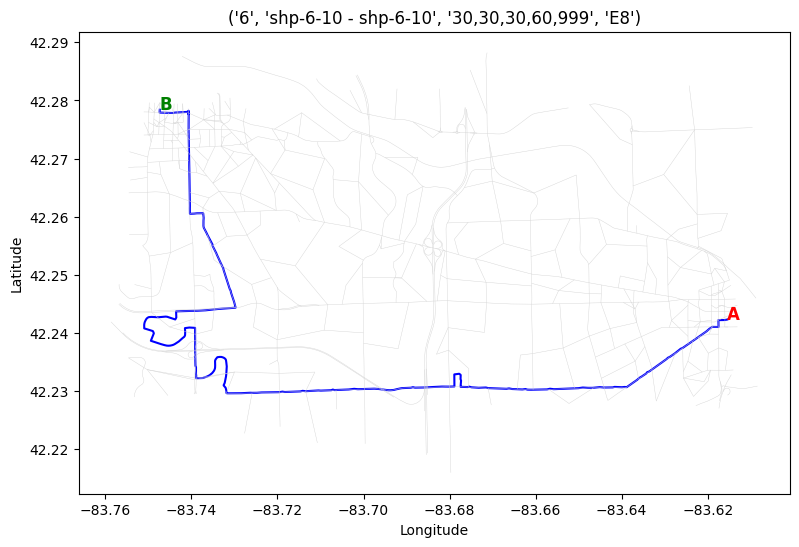

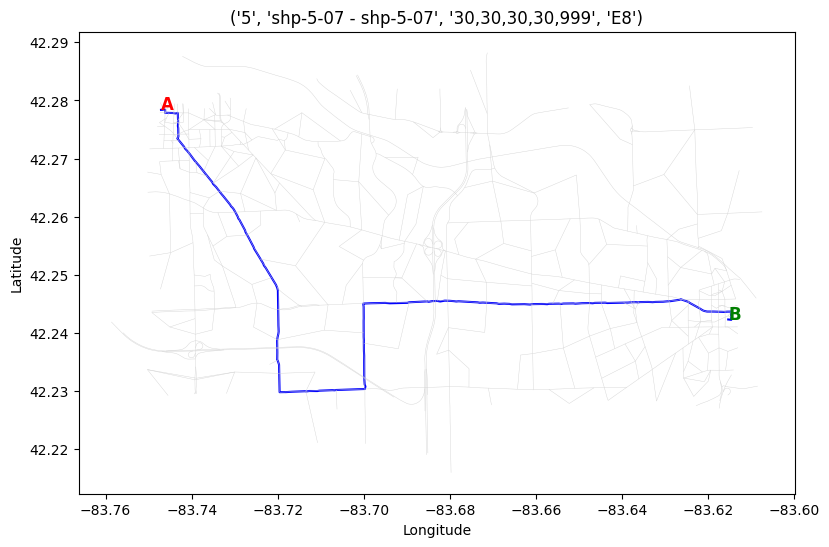

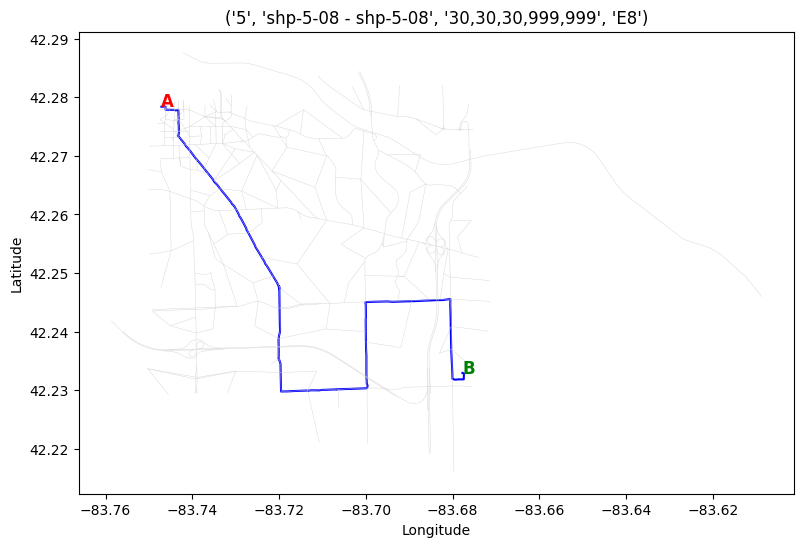

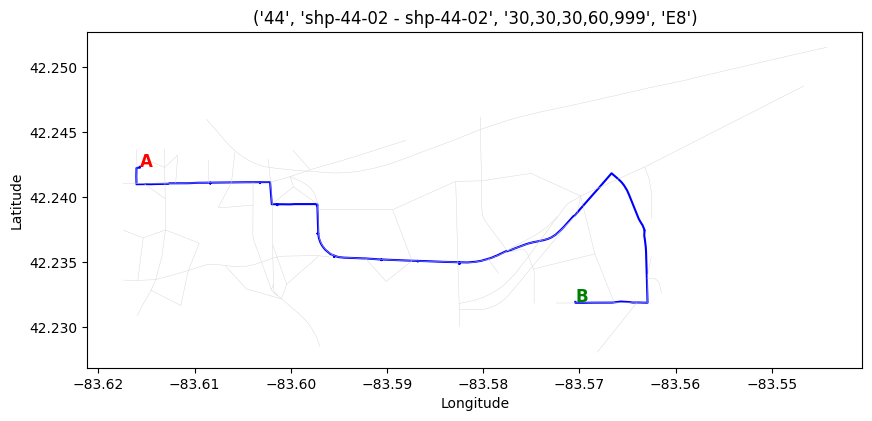

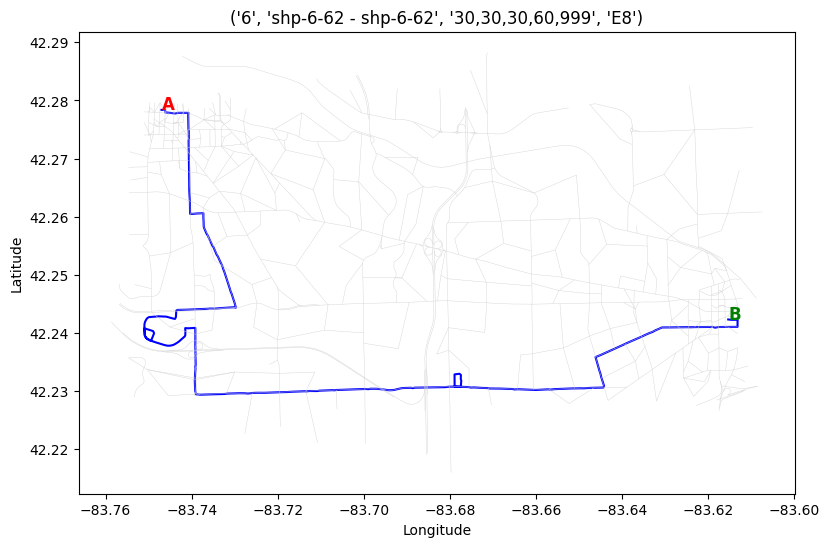

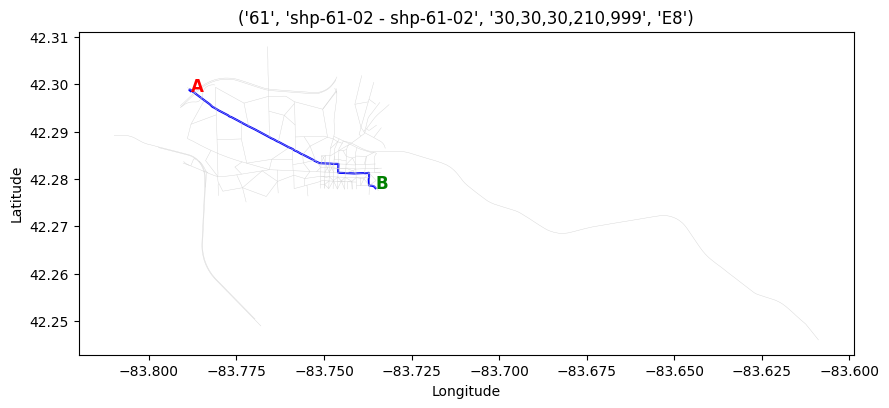

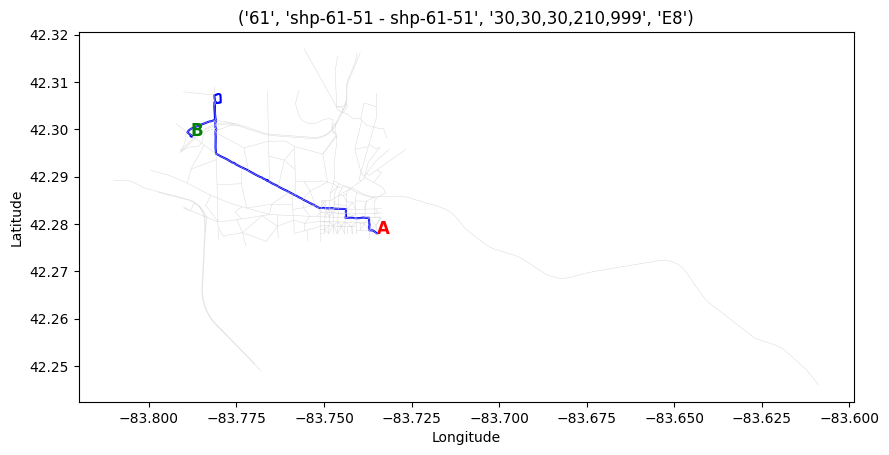

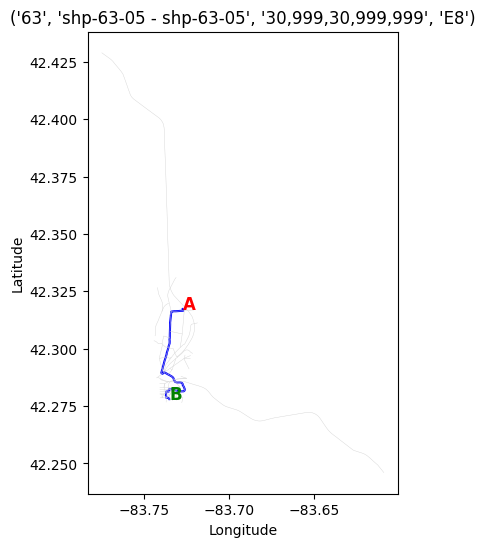

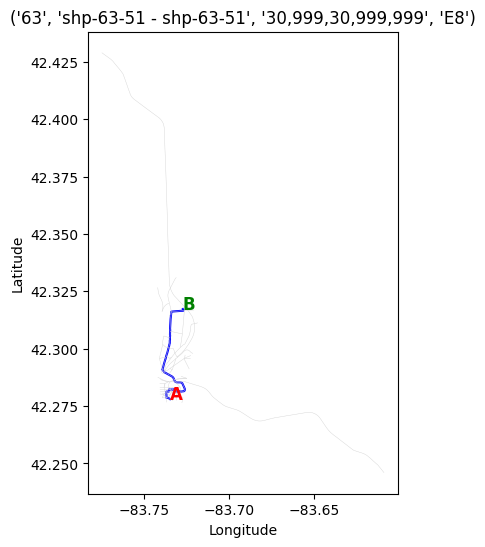

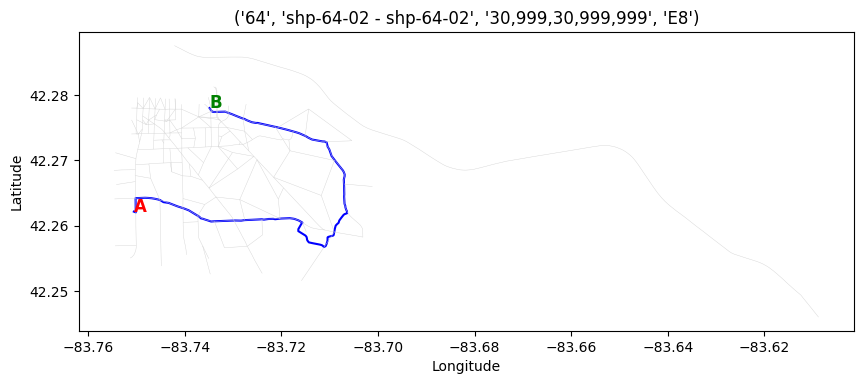

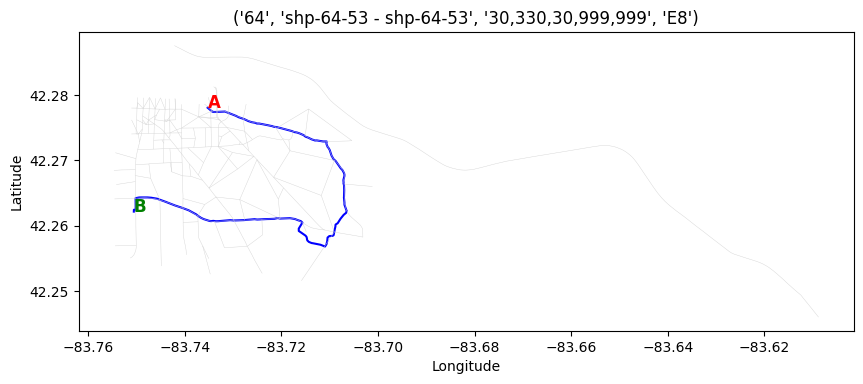

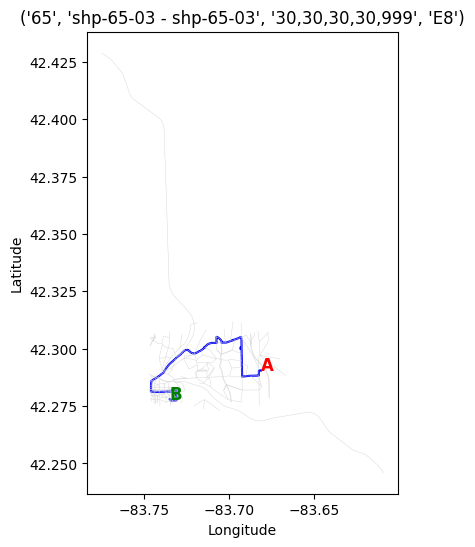

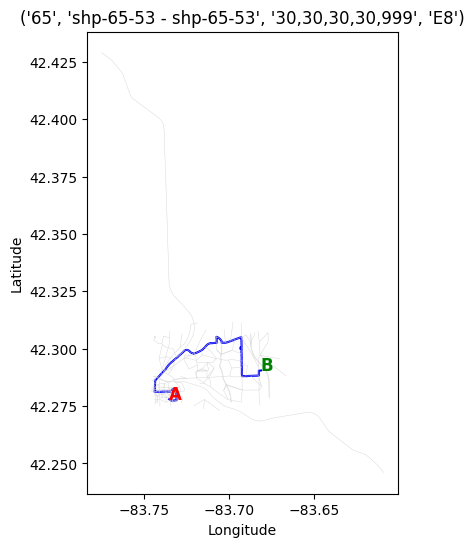

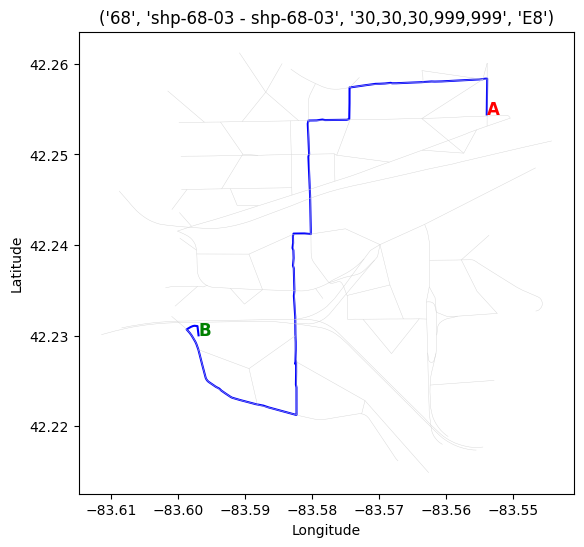

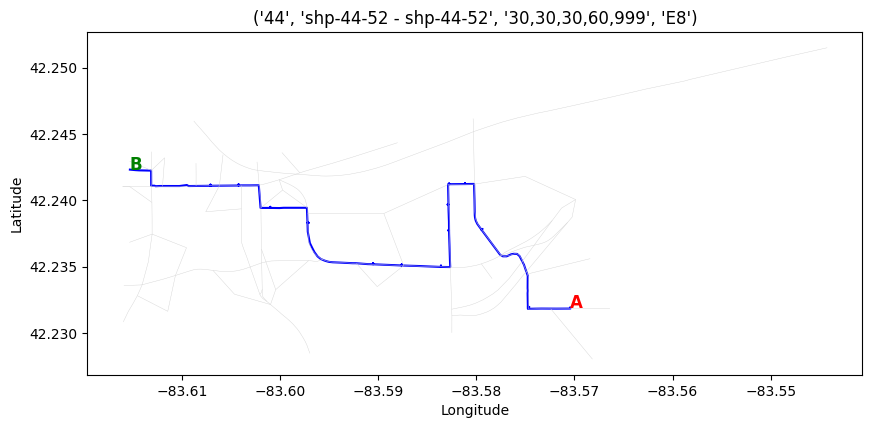

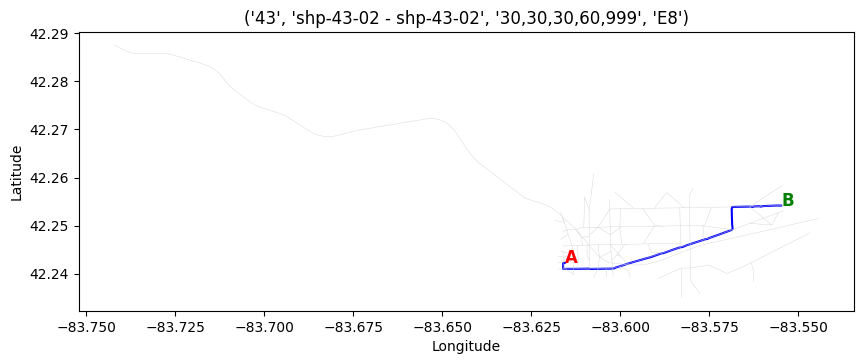

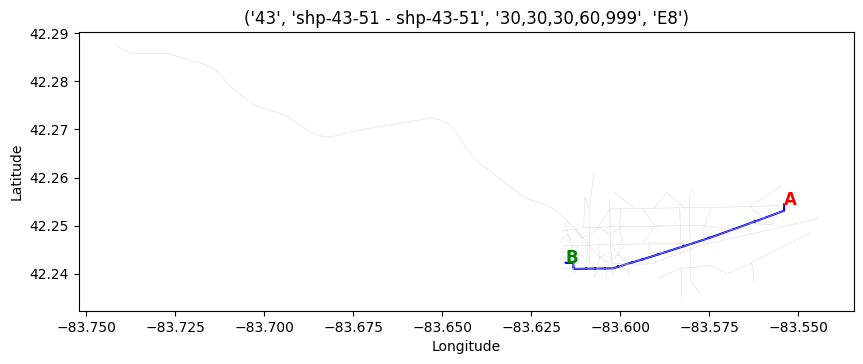

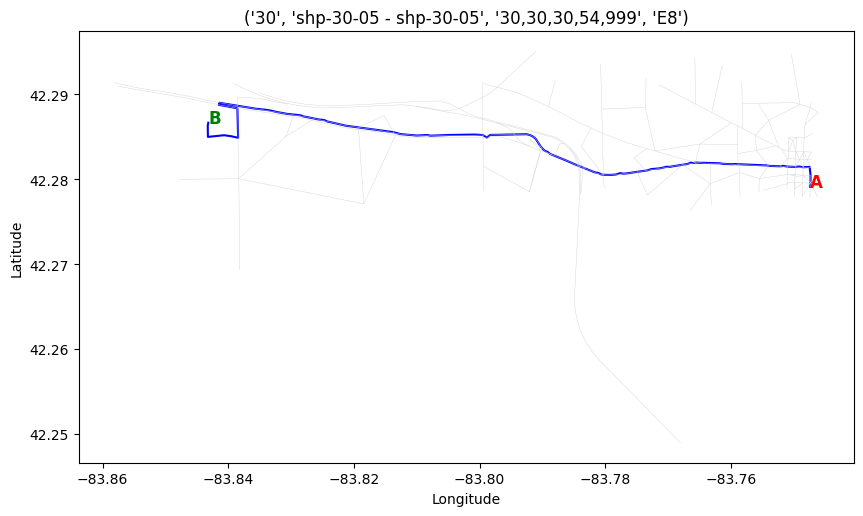

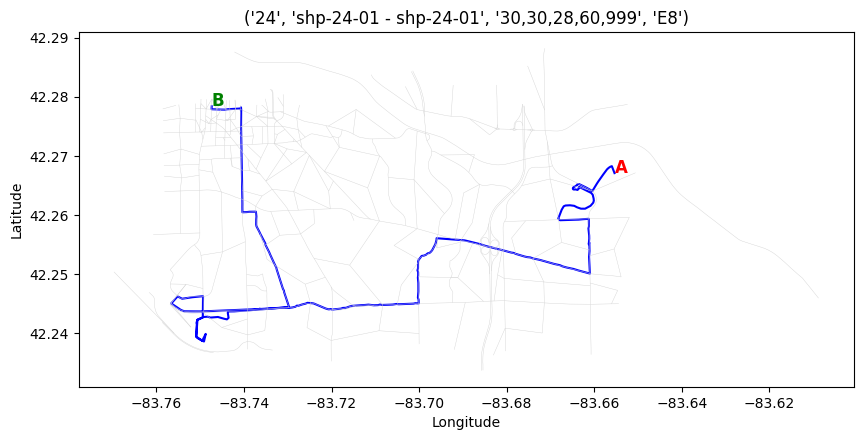

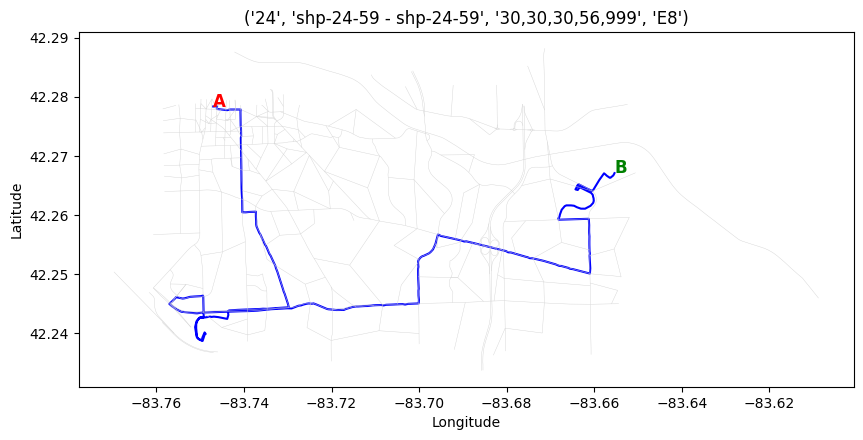

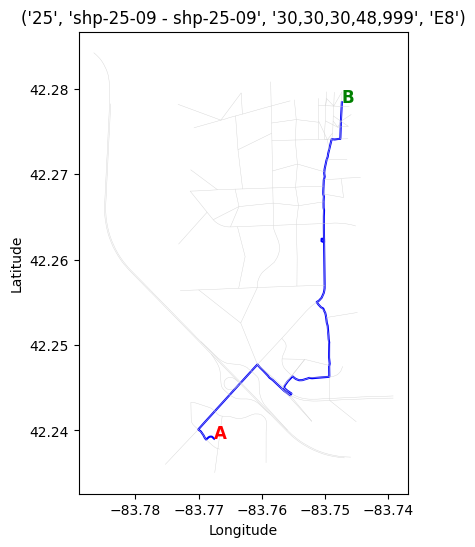

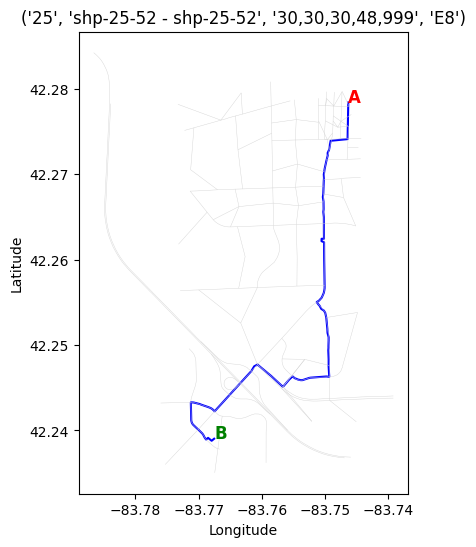

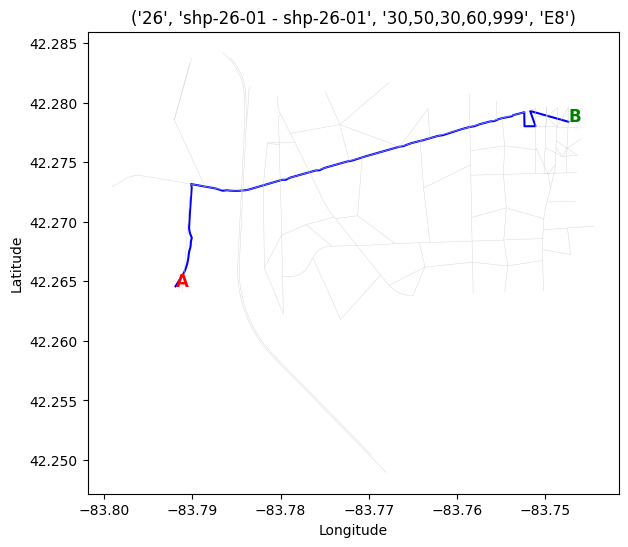

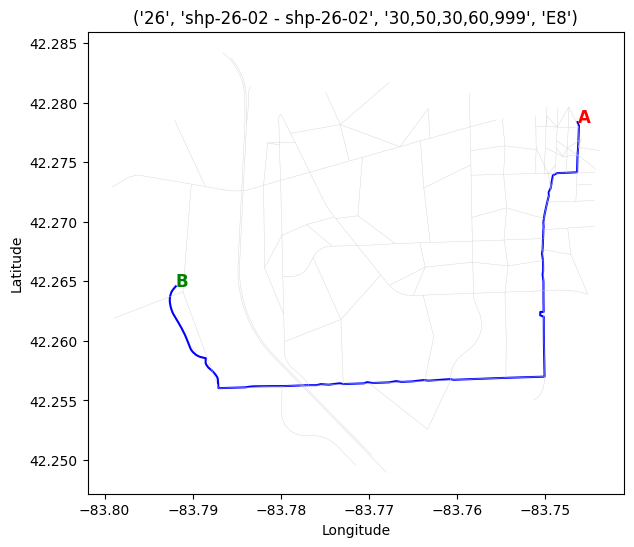

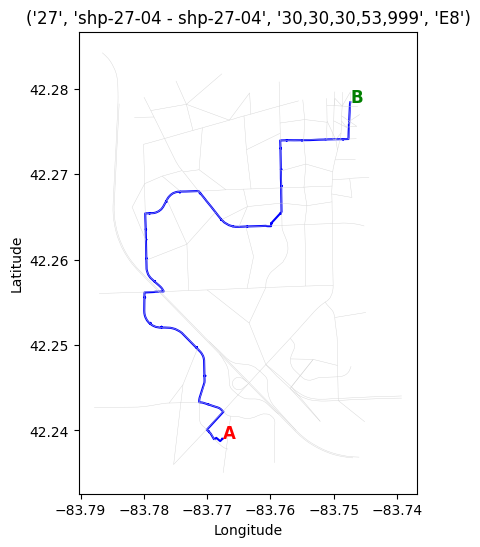

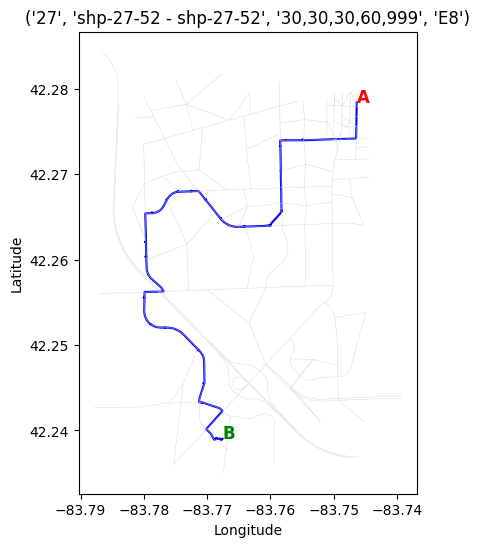

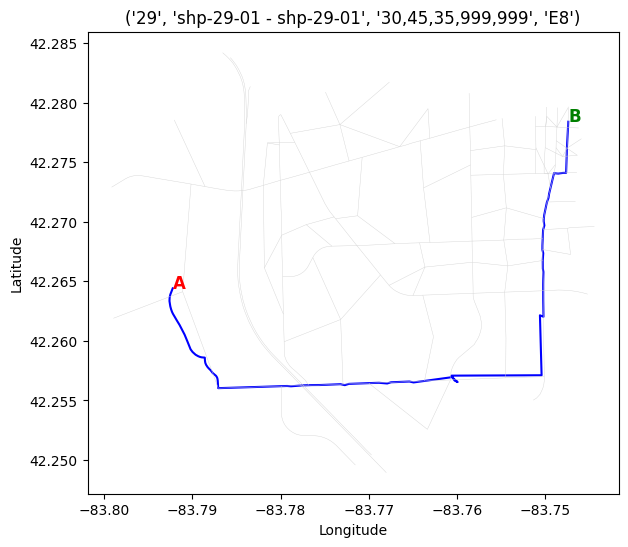

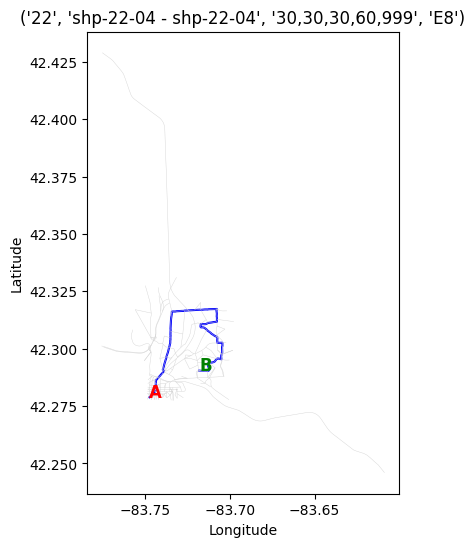

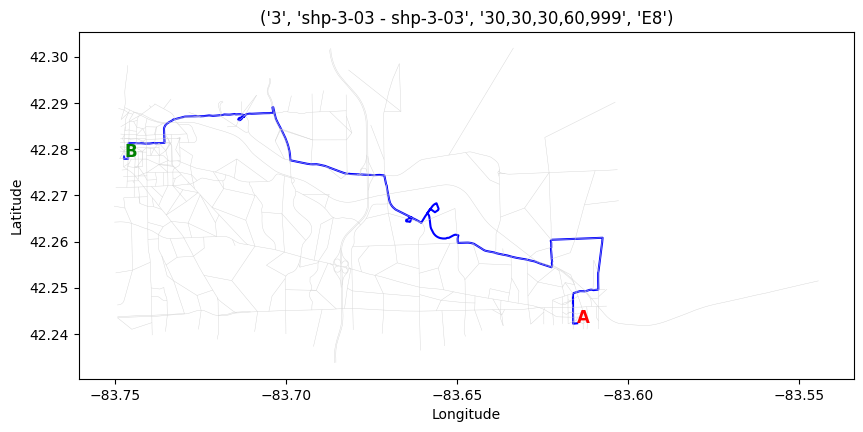

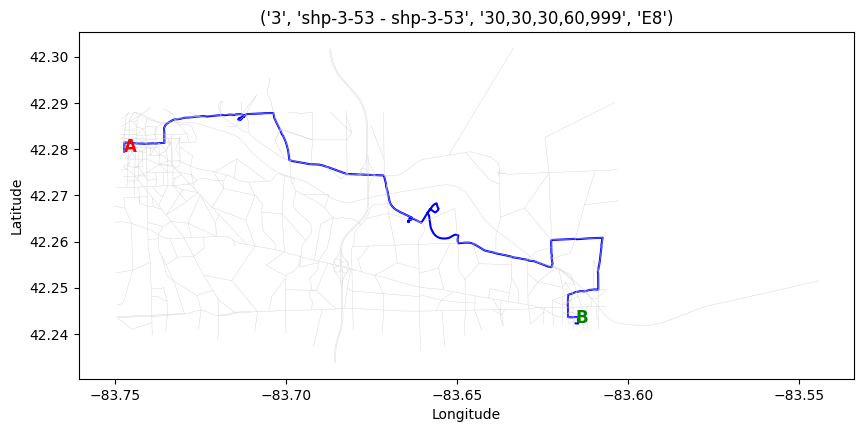

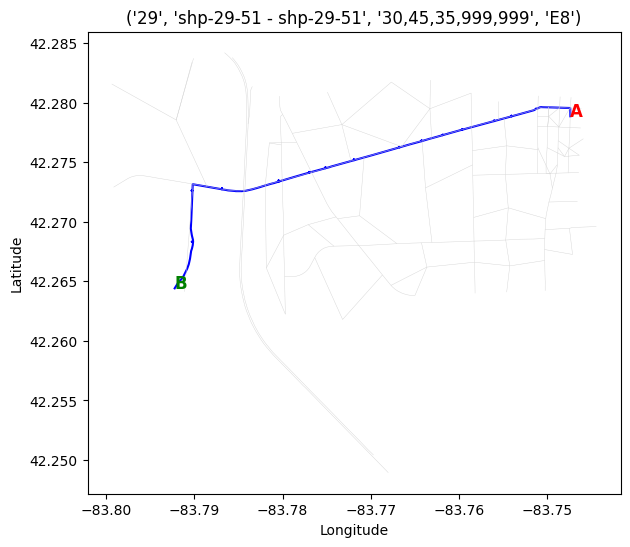

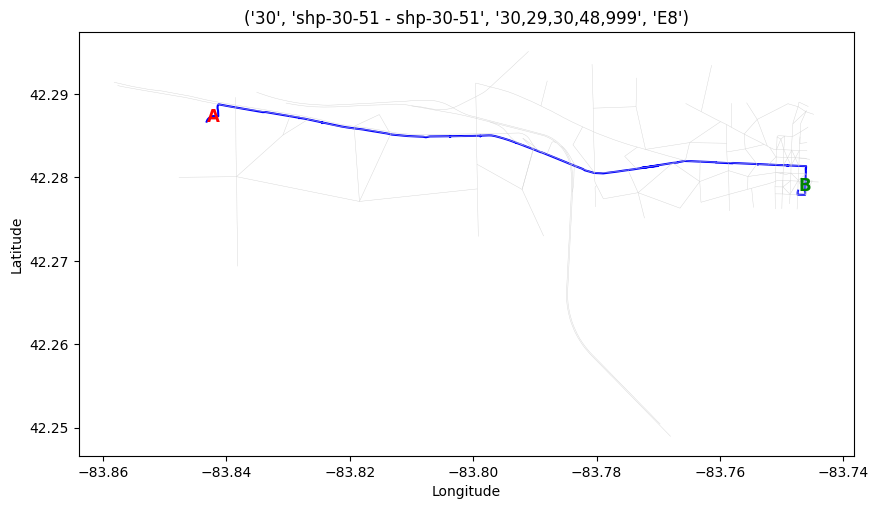

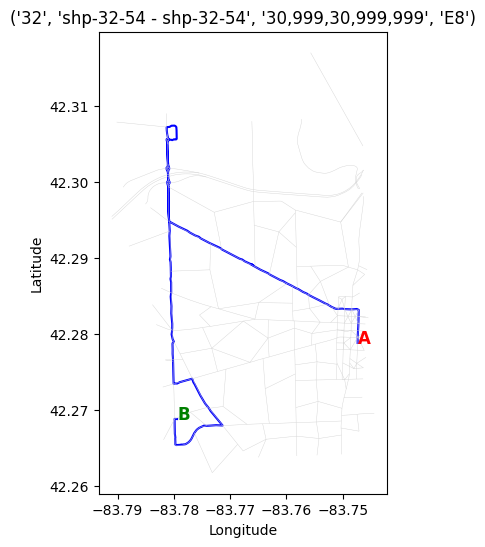

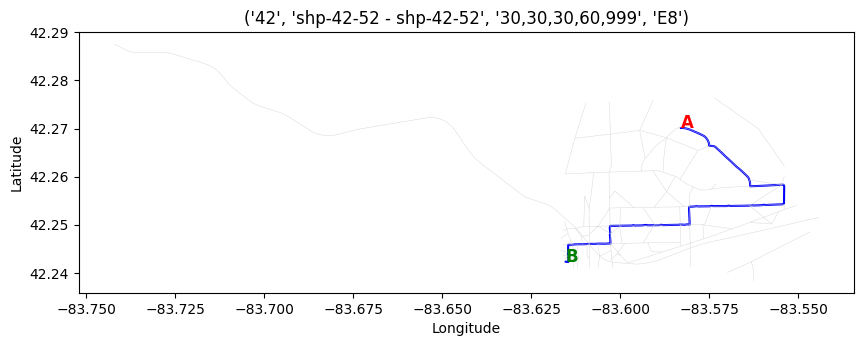

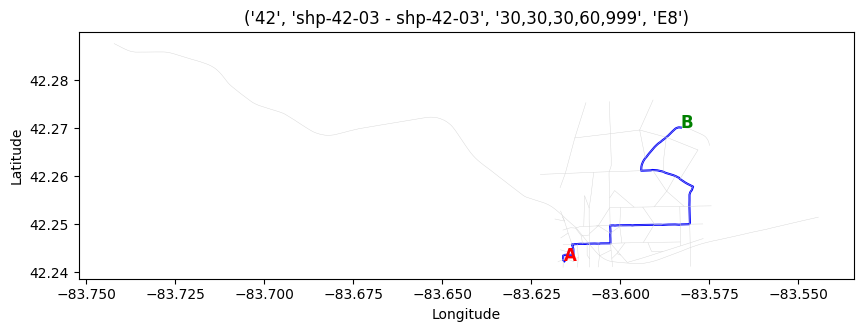

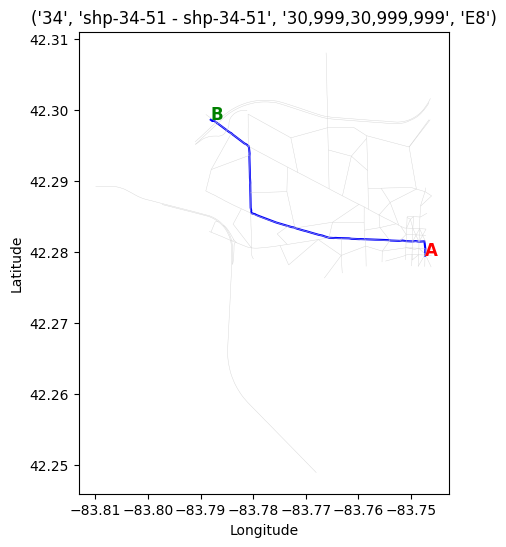

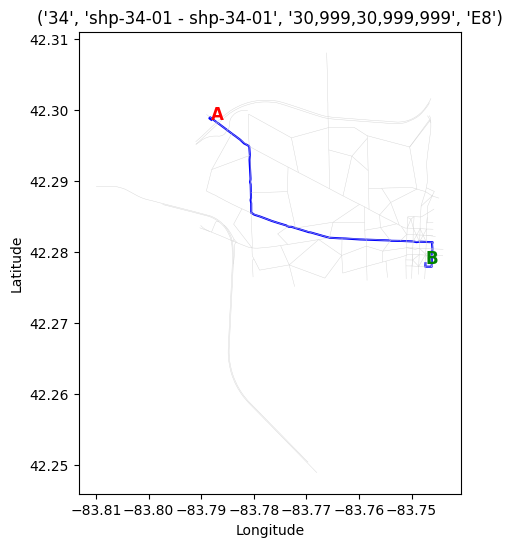

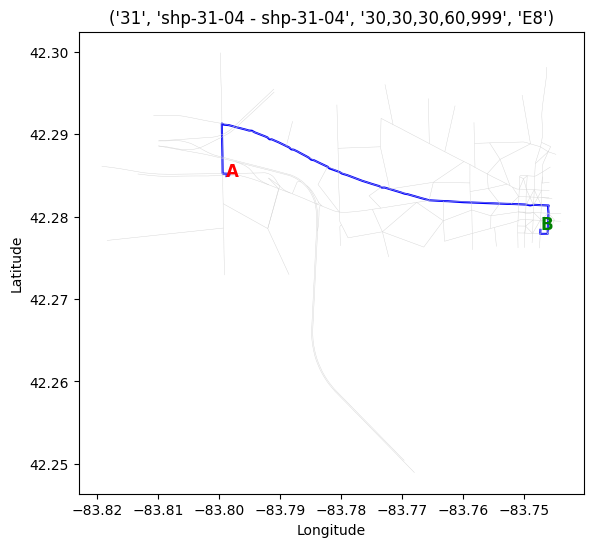

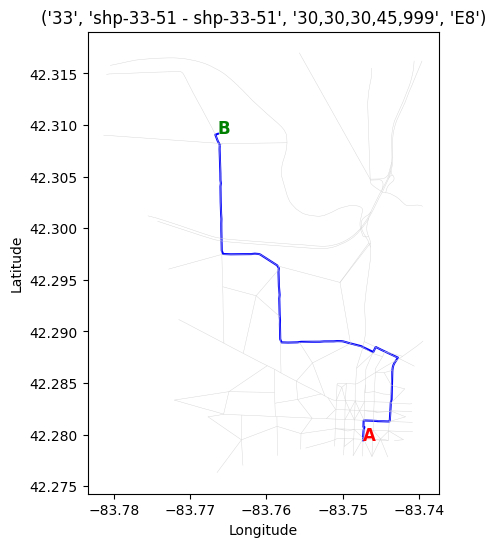

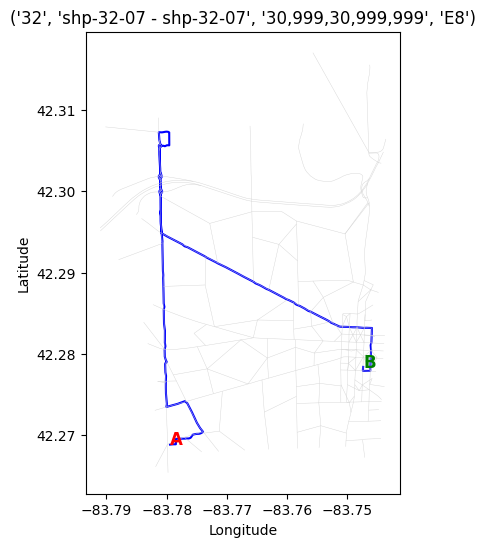

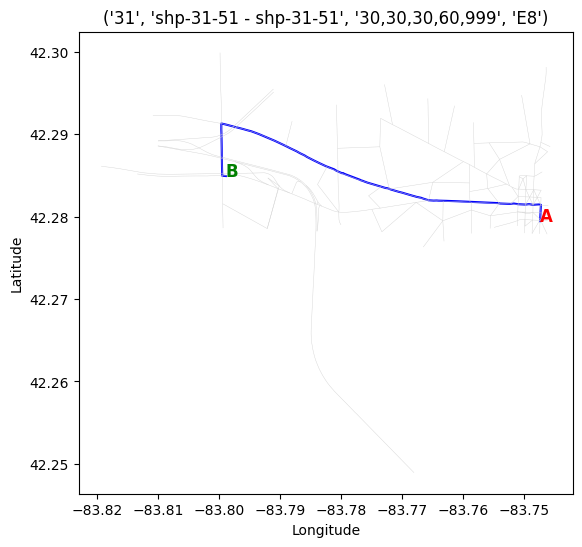

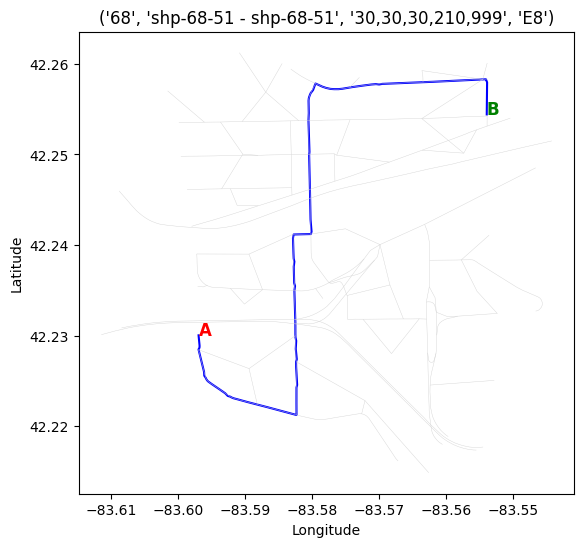

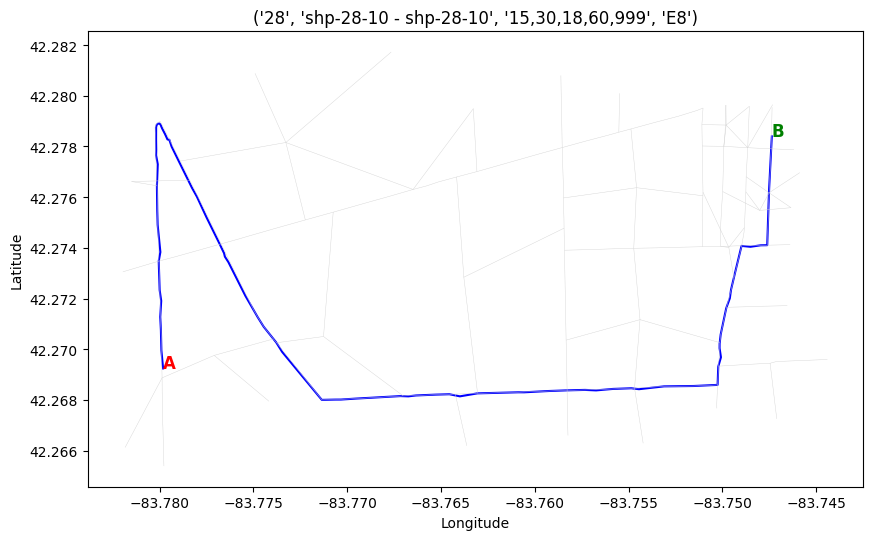

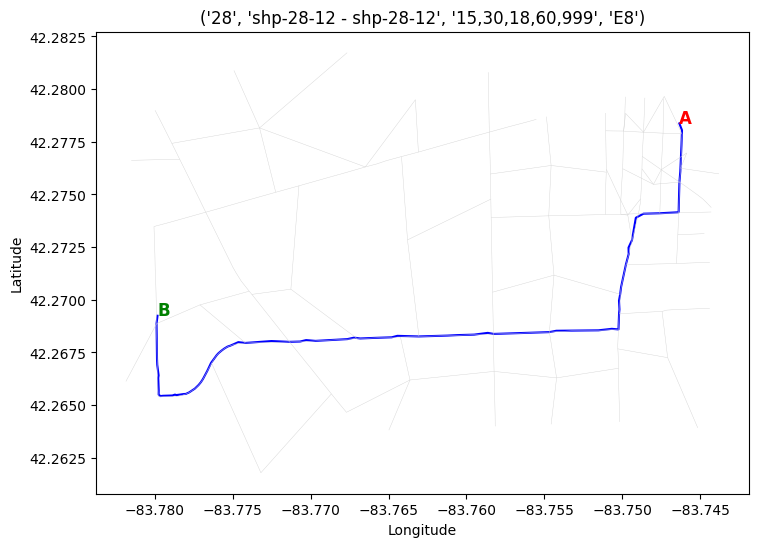

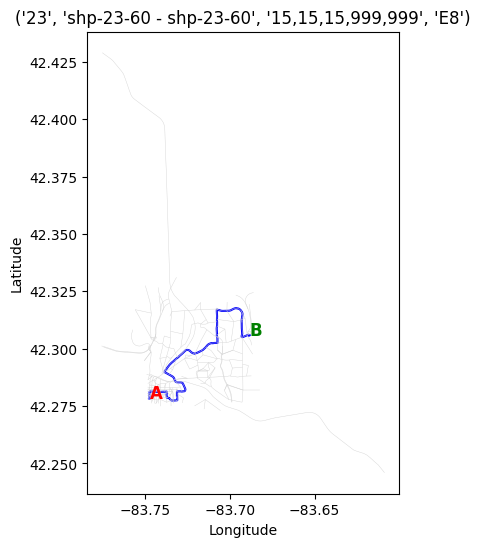

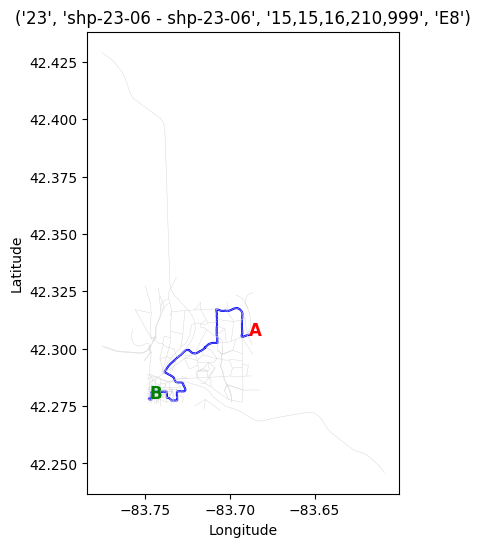

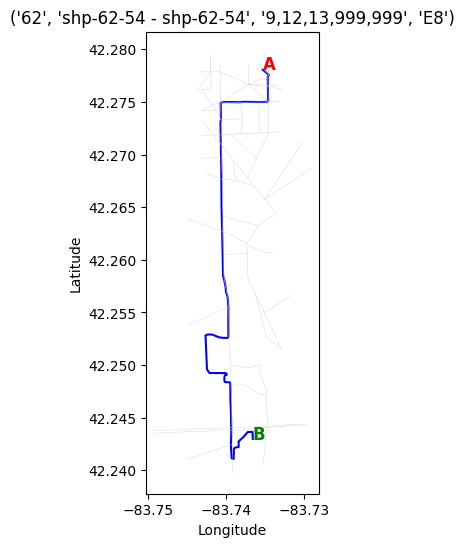

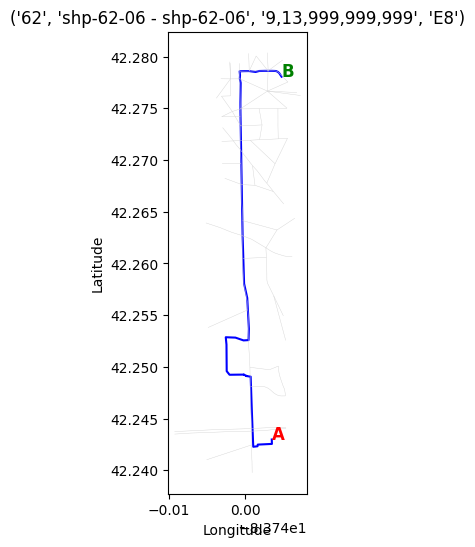

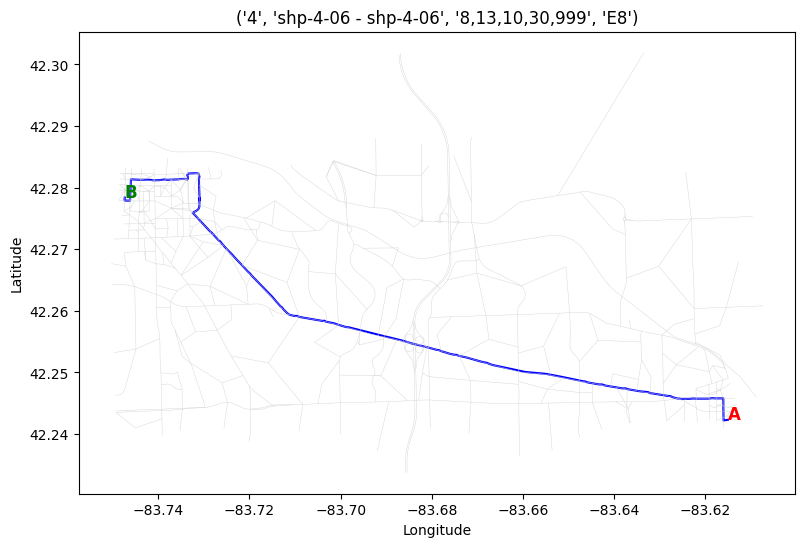

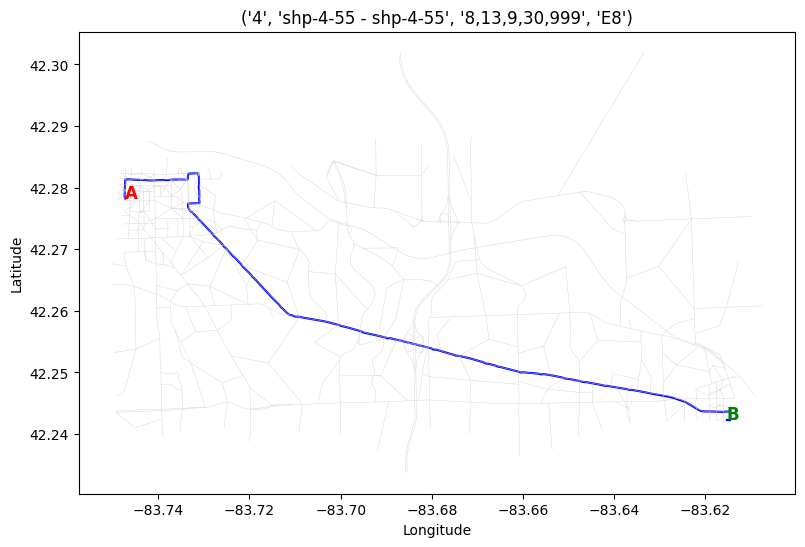

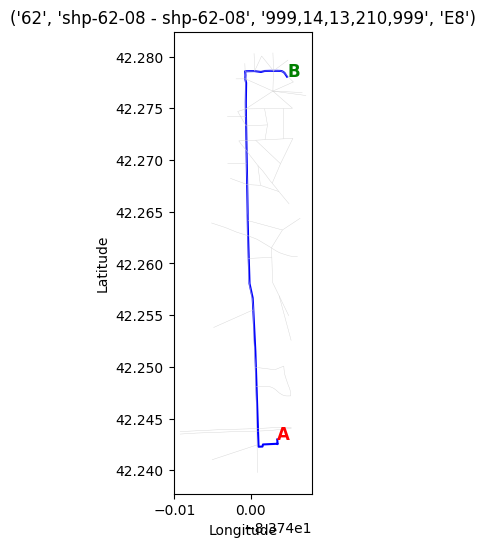

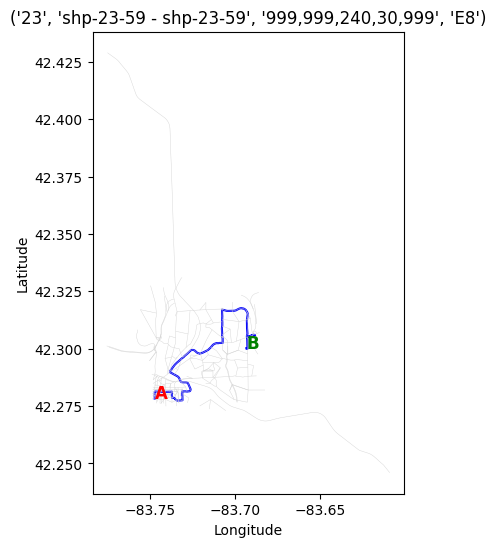

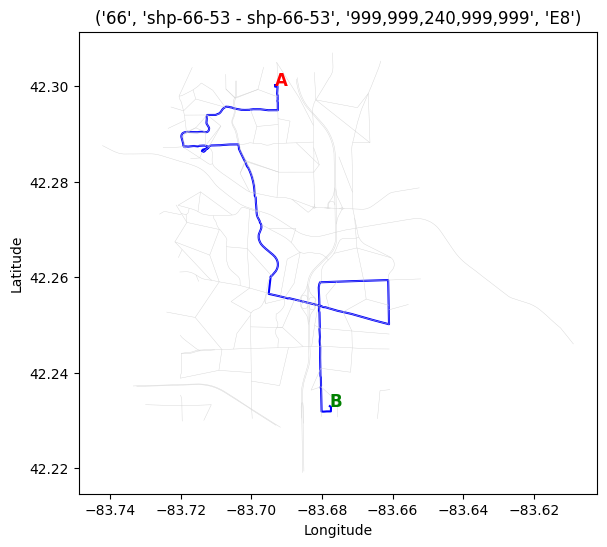

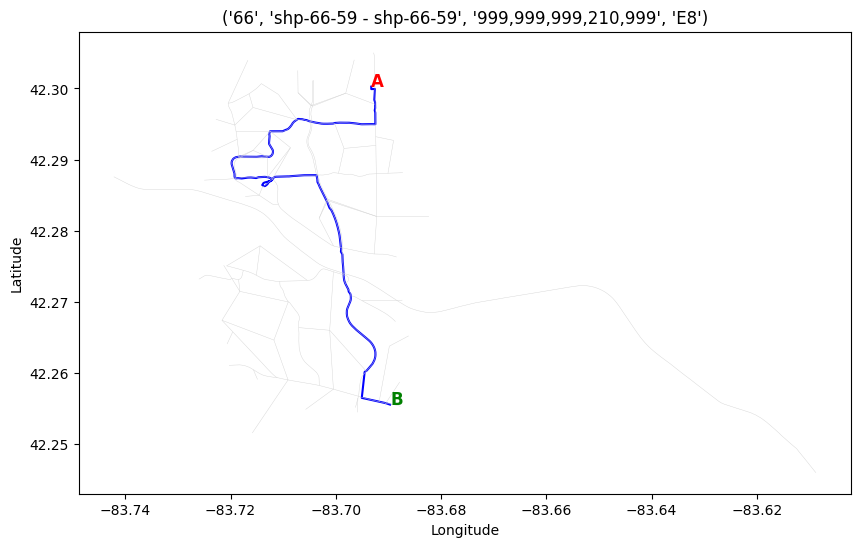

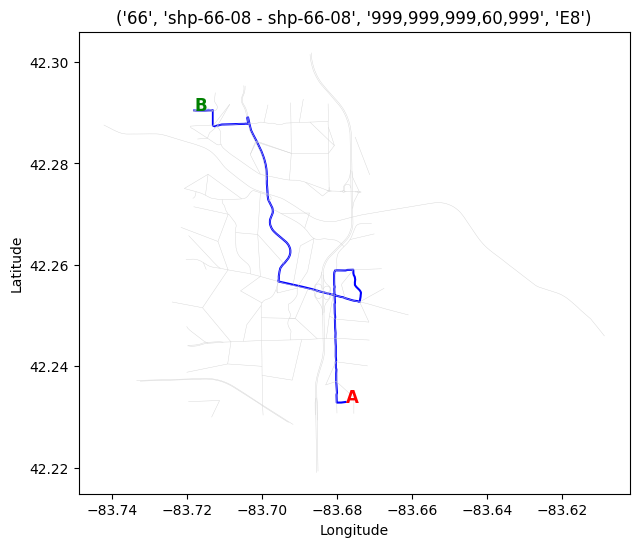

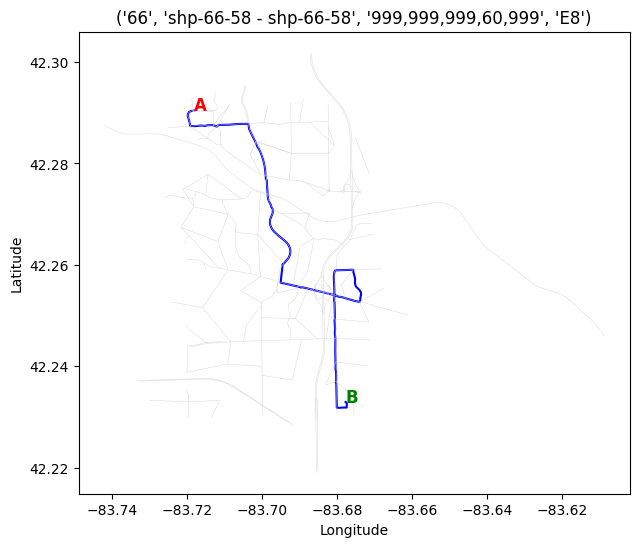

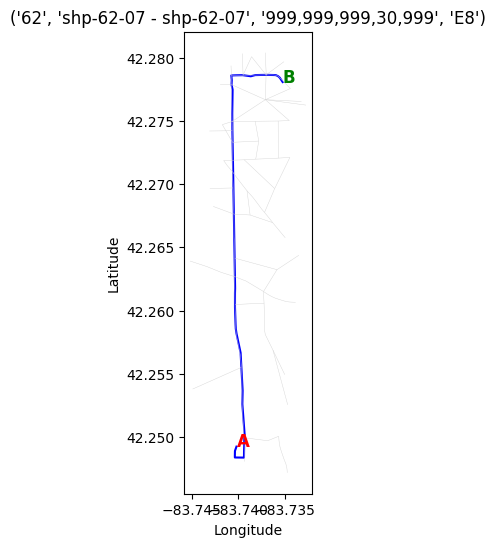

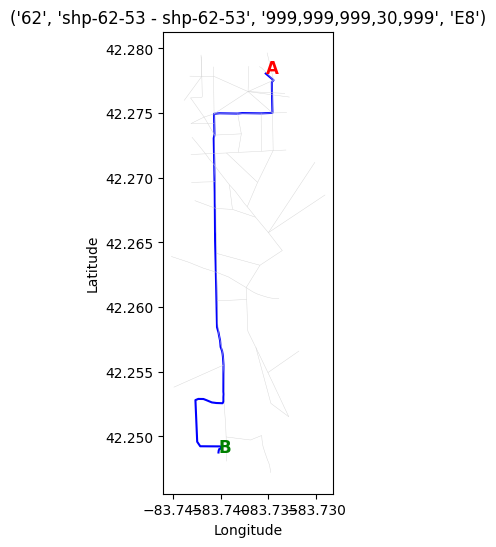

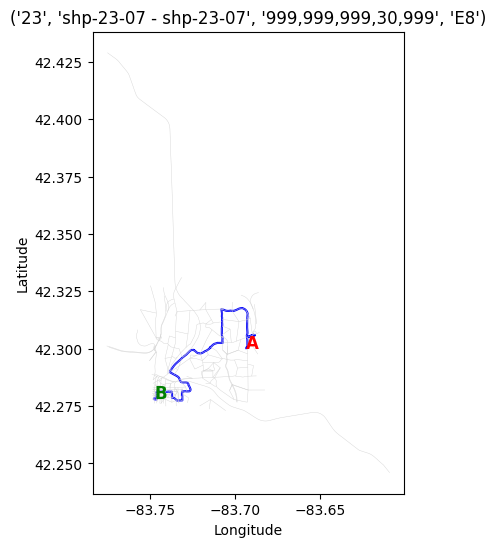

In [7]:
# Create a PDF file to store the plots WITHOUT stops

def natural_keys(text):
    """
    Sorts alphanumeric strings in human order.
    Example: shp-2, shp-10, shp-11 instead of shp-10, shp-11, shp-2
    """
    return [int(c) if c.isdigit() else c for c in re.split(r'(\d+)', str(text))]

route_order = index_df['gtfs_route'].tolist()
unique_routes = [r for r in route_order if r in shapes_df['shape_id'].unique()]

pdf_pages = pdf_backend.PdfPages(_join(map_location, auth + '_' + model + '_gtfs_plots_' + map_format + '.pdf'))

# Iterate over routes and plot their itineraries
for route in unique_routes:
    # Filter route data
    route_data_df = shapes_df[shapes_df['shape_id'] == route]
    shape_id = route_data_df['shape_id'].iloc[0]
    route_id = route_data_df['route_id'].iloc[1]
    model_route = route_data_df['model_route'].iloc[0]
    route_name = f'{model_route} - {shape_id}'    
    route_freq = route_data_df['freq'].iloc[0].split(',')
    modified_values = [value.replace('.0', '') for value in route_freq]
    route_freq = ','.join(modified_values)     
    if model == 'E8':  
        route_freq = route_freq + ',999'

    # Create a LineString geometry from route data
    route_geometry = LineString(zip(route_data_df['shape_pt_lon'], route_data_df['shape_pt_lat']))
    
    # Calculate bounding box (extent) of the route's geometry
    route_bbox = route_geometry.bounds
    
    # Crop the street map to the bounding box of the route
    cropped_map = street_map.cx[route_bbox[0]:route_bbox[2], route_bbox[1]:route_bbox[3]]
    
    # Plot the route line
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.plot(route_data_df['shape_pt_lon'], route_data_df['shape_pt_lat'], color='blue')

    # Label the first segment with 'A' and the last segment with 'B'
    for i in range(len(route_data_df['shape_pt_lon'])):
        if i == 0:
            label = 'A'
            color = 'red'
            #print ('a', route, route_data_df['shape_pt_lon'], route_data_df['shape_pt_lat'])
            ax.text(route_data_df['shape_pt_lon'].iloc[i], route_data_df['shape_pt_lat'].iloc[i], label, fontsize=12, color=color, fontweight='bold')
        elif i == len(route_data_df['shape_pt_lon']) - 1:
            label = 'B'
            color = 'green'
            #print ('a', route, route_coords[i][0], route_coords[i][1])
            ax.text(route_data_df['shape_pt_lon'].iloc[i], route_data_df['shape_pt_lat'].iloc[i], label, fontsize=12, color=color, fontweight='bold')
        else:
            continue

    # Plot the cropped street map on top of the route line with a thinner linewidth
    cropped_map.plot(ax=ax, color='lightgrey', linewidth=0.3)    
    
    ax.set_title(f'{route_id, route_name, route_freq, model}')
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    ax.grid(False)
    
    # Save the plot as a PDF page
    pdf_pages.savefig()
    
    # Show and close the plot
    plt.show()
    plt.close()

# Close the PDF file
pdf_pages.close()